In [1]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nibabel as nib
import os
import re
import xml.etree.ElementTree as ET
from tqdm import tqdm
from scipy.stats import entropy
from skimage.exposure import histogram
import cv2
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import gc
from torch.cuda.amp import autocast, GradScaler


2025-07-31 18:21:17.347616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753986077.707123      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753986077.803579      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
metadata = '/kaggle/input/adni-processed-complete/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv'
meta = pd.read_csv(metadata)
print(meta.head())

  Image Data ID     Subject Group Sex  Age Visit Modality  \
0       I112538  941_S_1311   MCI   M   70   m12      MRI   
1        I97341  941_S_1311   MCI   M   70   m06      MRI   
2        I97327  941_S_1311   MCI   M   69    sc      MRI   
3        I75150  941_S_1202    CN   M   78   m06      MRI   
4       I105437  941_S_1202    CN   M   79   m12      MRI   

                                  Description       Type   Acq Date Format  \
0    MPR; GradWarp; B1 Correction; N3; Scaled  Processed  6/01/2008  NiFTI   
1  MPR-R; GradWarp; B1 Correction; N3; Scaled  Processed  9/27/2007  NiFTI   
2    MPR; GradWarp; B1 Correction; N3; Scaled  Processed  3/02/2007  NiFTI   
3    MPR; GradWarp; B1 Correction; N3; Scaled  Processed  8/24/2007  NiFTI   
4    MPR; GradWarp; B1 Correction; N3; Scaled  Processed  2/28/2008  NiFTI   

   Downloaded  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
matching_index = meta[(meta['Image Data ID'] == 'I112538') & (meta['Subject'] == '941_S_1311')].index
matching_index

Index([0], dtype='int64')

In [4]:
meta.shape

(2294, 12)

In [5]:
base_path = "/kaggle/input/adni-processed-complete/ADNI_Processed/ADNI_Processed"
subjects = []
for folder in os.listdir(base_path):
    for subject in os.listdir(os.path.join(base_path, folder)):
        subjects.append(subject)

subjects = list(set(subjects))
l_s = len(subjects)
print(f"Total Subjects: {l_s}")

Total Subjects: 639


In [6]:
import random
random.shuffle(subjects)
train_subjects = subjects[:int(0.7*l_s)]
val_subjects = subjects[int(0.7*l_s):int(0.8*l_s)]
test_subjects = subjects[int(0.8*l_s):]

print(f"Train subjects: {len(train_subjects)}")
print(f"Validation subjects: {len(val_subjects)}")
print(f"Test subjects: {len(test_subjects)}")


Train subjects: 447
Validation subjects: 64
Test subjects: 128


In [7]:
train_file_paths = []
val_file_paths = []
test_file_paths = []

for folder in os.listdir(base_path):
    print(f"Processing folder: {folder}")
    for subject in os.listdir(os.path.join(base_path, folder)):
        for image in os.listdir(os.path.join(base_path, folder, subject)):
            for file in os.listdir(os.path.join(base_path, folder, subject, image)):
                file_path = os.path.join(base_path, folder, subject, image, file)
                
                # Find corresponding metadata
                target_idx = meta[((meta['Subject'] == subject) & (meta['Image Data ID'] == image))].index
                
                # Skip if no metadata found for the image
                if target_idx.empty:
                    continue
                
                label_str = str(meta.iloc[target_idx[0], 2])
                
                # MODIFICATION: Include all three classes (AD, CN, MCI)
                # The original code skipped 'MCI'. This has been removed.
                
                if subject in train_subjects:
                    train_file_paths.append((label_str, file_path))
                elif subject in val_subjects:
                    val_file_paths.append((label_str, file_path))
                elif subject in test_subjects:
                    test_file_paths.append((label_str, file_path))
                else:
                    # This case should ideally not happen with the current logic
                    print("Error: Subject not in any split")


Processing folder: ADNI1_Complete 1Yr 1.5T8
Processing folder: ADNI1_Complete 1Yr 1.5T1
Processing folder: ADNI1_Complete 1Yr 1.5T6
Processing folder: ADNI1_Complete 1Yr 1.5T4
Processing folder: ADNI1_Complete 1Yr 1.5T9
Processing folder: ADNI1_Complete 1Yr 1.5T3
Processing folder: ADNI1_Complete 1Yr 1.5T5
Processing folder: ADNI1_Complete 1Yr 1.5T2
Processing folder: ADNI1_Complete 1Yr 1.5T
Processing folder: ADNI1_Complete 1Yr 1.5T7


In [8]:
print(f"Number of training files: {len(train_file_paths)}")
print(f"Number of validation files: {len(val_file_paths)}")
print(f"Number of testing files: {len(test_file_paths)}")

Number of training files: 1619
Number of validation files: 231
Number of testing files: 444


In [9]:
def center_crop(image, crop_size=128):
    """Crops the center of an image."""
    h, w = image.shape
    if h < crop_size or w < crop_size:
        return None
    top = (h - crop_size) // 2
    left = (w - crop_size) // 2
    return image[top:top+crop_size, left:left+crop_size]

def image_entropy(img):
    """Calculates the entropy of an image."""
    hist, _ = histogram(img)
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)

In [10]:
class EntropySlicesDataset(Dataset):
    def __init__(self, actual_paths, N=100, crop_size=128, transform=None):
        """
        Args:
            actual_paths: list of tuples (label_str, path_to_nifti)
            N: number of top entropy slices per subject
            crop_size: center crop size
            transform: optional torchvision transforms
        """
        self.actual_paths = actual_paths
        self.N = N
        self.crop_size = crop_size
        self.transform = transform
        
        # MODIFICATION: Create a mapping for three classes
        self.label_map = {'AD': 0, 'CN': 1, 'MCI': 2}
        
        self.samples = self._filter_valid_subjects()

    def _filter_valid_subjects(self):
        """Pre-screens subjects to ensure they have enough valid slices."""
        valid = []
        print("Pre-scanning subjects to exclude insufficient-slice cases...")
        for label, path in tqdm(self.actual_paths):
            try:
                scan = nib.load(path)
                data = scan.get_fdata()
                slice_count = 0

                for axis in [0, 1, 2]:
                    for i in range(data.shape[axis]):
                        if axis == 0: slice_ = data[i, :, :]
                        elif axis == 1: slice_ = data[:, i, :]
                        else: slice_ = data[:, :, i]

                        if center_crop(slice_, crop_size=self.crop_size) is not None:
                            slice_count += 1
                
                if slice_count >= self.N:
                    valid.append((label, path))
                else:
                    print(f"[!] Skipped subject at {path}: only {slice_count} valid slices found, need {self.N}")
            except Exception as e:
                print(f"Error processing {path}: {e}")
        return valid

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label_str, path = self.samples[idx]
        scan = nib.load(path)
        data = scan.get_fdata()
        
        # MODIFICATION: Use the label map for 3 classes
        label_val = self.label_map[label_str]

        slice_info = []
        for axis in [0, 1, 2]:
            for i in range(data.shape[axis]):
                if axis == 0: slice_ = data[i, :, :]
                elif axis == 1: slice_ = data[:, i, :]
                else: slice_ = data[:, :, i]

                cropped = center_crop(slice_, crop_size=self.crop_size)
                if cropped is None:
                    continue

                ent = image_entropy(cropped)
                slice_info.append((ent, cropped))

        slice_info.sort(reverse=True, key=lambda x: x[0])
        top_slices = slice_info[:self.N]

        subject_slices = []
        for _, slice_2d in top_slices:
            slice_2d = slice_2d[..., np.newaxis]
            slice_rgb = np.repeat(slice_2d, 3, axis=-1)
            slice_rgb_chw = np.transpose(slice_rgb, (2, 0, 1))
            subject_slices.append(slice_rgb_chw)

        subject_volume = np.stack(subject_slices, axis=0)
        subject_volume = torch.from_numpy(subject_volume).float()

        if self.transform:
            subject_volume = self.transform(subject_volume)

        return subject_volume, label_val

In [11]:
train_dataset = EntropySlicesDataset(train_file_paths, N=100, crop_size=128)
val_dataset   = EntropySlicesDataset(val_file_paths, N=100, crop_size=128)
test_dataset  = EntropySlicesDataset(test_file_paths, N=100, crop_size=128)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

Pre-scanning subjects to exclude insufficient-slice cases...


100%|██████████| 1619/1619 [07:54<00:00,  3.41it/s]


Pre-scanning subjects to exclude insufficient-slice cases...


100%|██████████| 231/231 [01:09<00:00,  3.32it/s]


Pre-scanning subjects to exclude insufficient-slice cases...


100%|██████████| 444/444 [02:09<00:00,  3.43it/s]


In [12]:
class ResNetPerSlice(nn.Module):
    """Feature extractor for a single 2D slice."""
    def __init__(self, dropout_p=0.3):
        super().__init__()
        resnet = models.resnet152(weights='IMAGENET1K_V1')
        modules = list(resnet.children())[:-2]
        self.features = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout2d(p=dropout_p)

    def forward(self, x):
        x = self.features(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        return x

class AttentionXAIClassifier(nn.Module):
    """Full classifier model with attention mechanism."""
    def __init__(self, feature_dim=2048, attn_hidden=128, num_classes=3, dropout_p=0.5):
        super().__init__()
        self.cnn_per_slice = ResNetPerSlice(dropout_p=0.3)

        self.attn_fc = nn.Sequential(
            nn.Linear(feature_dim, attn_hidden, bias=False),
            nn.LayerNorm(attn_hidden),
            nn.Tanh(),
            nn.Dropout(p=dropout_p),
            nn.Linear(attn_hidden, 1)
        )

        # MODIFICATION: Classifier head adapted for `num_classes`
        self.classifier_fc = nn.Sequential(
            nn.Linear(feature_dim, 128, bias=False),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, noise_p=0.01):
        B, N, C, H, W = x.shape

        if self.training and noise_p > 0:
            x = x + torch.randn_like(x) * noise_p

        x = x.view(B * N, C, H, W)
        features = self.cnn_per_slice(x)
        features = features.view(B, N, -1)

        w = self.attn_fc(features.view(-1, features.size(-1)))
        w = w.view(B, N)
        alpha = F.softmax(w, dim=1).unsqueeze(-1)

        pooled = torch.sum(alpha * features, dim=1)
        logits = self.classifier_fc(pooled)

        return logits, alpha

In [13]:

def train(model, train_loader, val_loader, device, num_epochs=10, lr=1e-4):
    """Training and validation loop for the model."""
    
    # MODIFICATION: Use CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()
    
    # MODIFICATION: Optimizer only targets parameters that are not frozen
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-5)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6
    )
    
    scaler = GradScaler()
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        # --- Training phase ---
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]")

        for X, y in pbar:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad()

            with autocast():
                outputs, _ = model(X)
                # MODIFICATION: Use CrossEntropyLoss directly with logits and integer labels
                loss = criterion(outputs, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * X.size(0)
            
            # MODIFICATION: Get predictions for multi-class
            preds = torch.argmax(outputs, 1)
            train_correct += (preds == y).sum().item()
            total += y.size(0)

            pbar.set_postfix(loss=loss.item(), acc=100 * train_correct / total)

        avg_train_loss = train_loss / total
        train_acc = 100 * train_correct / total

        # --- Validation phase ---
        model.eval()
        val_loss, val_correct, total_val = 0.0, 0, 0

        with torch.no_grad(), autocast():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device, non_blocking=True), y_val.to(device, non_blocking=True)
                outputs, _ = model(X_val)
                loss = criterion(outputs, y_val)

                val_loss += loss.item() * X_val.size(0)
                preds = torch.argmax(outputs, 1)
                val_correct += (preds == y_val).sum().item()
                total_val += y_val.size(0)

        avg_val_loss = val_loss / total_val
        val_acc = 100 * val_correct / total_val

        print(f"Epoch {epoch:02d}: "
              f"Train Loss {avg_train_loss:.4f} Acc {train_acc:.2f}%, "
              f"Val Loss {avg_val_loss:.4f} Acc {val_acc:.2f}%")

        scheduler.step(avg_val_loss)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_path = "/kaggle/input/modifed-axial/pytorch/default/2/axial_weights(1).pth" 

# 1. Instantiate model for the new task (3 classes)
model = AttentionXAIClassifier(num_classes=3)

# 2. Load the state dictionary from the pre-trained model
# Ensure the weights file 'axial_weights.pth' is in the root directory or provide the correct path.
if os.path.exists(weights_path):
    print(f"Loading pre-trained weights from {weights_path}")
    state_dict = torch.load(weights_path, map_location=device)
    
    # Handle cases where weights were saved with DataParallel
    if all(key.startswith('module.') for key in state_dict.keys()):
        print("Removing 'module.' prefix from state_dict keys.")
        state_dict = {k.partition('module.')[2]: v for k, v in state_dict.items()}

    # FIX: Remove the weights of the final classification layer from the loaded state_dict
    # as its size is different in the new model (1 output vs 3 outputs).
    state_dict.pop('classifier_fc.4.weight', None)
    state_dict.pop('classifier_fc.4.bias', None)

    # Now, load the weights. strict=False will gracefully ignore the missing keys.
    model.load_state_dict(state_dict, strict=False)
    print("Weights loaded successfully.")

    # 3. Freeze the feature extraction layers
    print("Freezing feature extraction layers (cnn_per_slice).")
    for param in model.cnn_per_slice.parameters():
        param.requires_grad = False
    # Optionally, you can also freeze the attention layers if you want
    # for param in model.attn_fc.parameters():
    #     param.requires_grad = False
else:
    print(f"WARNING: Pre-trained weights not found at '{weights_path}'. Training from scratch.")

# Handle multi-GPU
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model.to(device) 

# 4. Train the model (only the unfrozen layers will be updated)
train(model, train_loader, val_loader, device, num_epochs=10, lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 217MB/s] 


Loading pre-trained weights from /kaggle/input/modifed-axial/pytorch/default/2/axial_weights(1).pth
Removing 'module.' prefix from state_dict keys.
Weights loaded successfully.
Freezing feature extraction layers (cnn_per_slice).
Using 2 GPUs


/tmp/ipykernel_36/2419306444.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10 [Train]:   0%|          | 0/405 [00:00<?, ?it/s]/tmp/ipykernel_36/2419306444.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10 [Train]: 100%|██████████| 405/405 [10:41<00:00,  1.58s/it, acc=59.4, loss=0.959]
/tmp/ipykernel_36/2419306444.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 01: Train Loss 0.7909 Acc 59.36%, Val Loss 0.7585 Acc 58.01%


Epoch 2/10 [Train]: 100%|██████████| 405/405 [10:44<00:00,  1.59s/it, acc=62.4, loss=0.726]


Epoch 02: Train Loss 0.7296 Acc 62.45%, Val Loss 0.7327 Acc 66.23%


Epoch 3/10 [Train]: 100%|██████████| 405/405 [10:26<00:00,  1.55s/it, acc=65.7, loss=0.513]


Epoch 03: Train Loss 0.7080 Acc 65.72%, Val Loss 0.7356 Acc 67.10%


Epoch 4/10 [Train]: 100%|██████████| 405/405 [10:25<00:00,  1.54s/it, acc=66.4, loss=0.399]


Epoch 04: Train Loss 0.7059 Acc 66.40%, Val Loss 0.7375 Acc 64.94%


Epoch 5/10 [Train]: 100%|██████████| 405/405 [10:26<00:00,  1.55s/it, acc=64.9, loss=0.55] 


Epoch 05: Train Loss 0.6986 Acc 64.92%, Val Loss 0.7364 Acc 65.37%


Epoch 6/10 [Train]: 100%|██████████| 405/405 [10:27<00:00,  1.55s/it, acc=66.5, loss=0.409]


Epoch 06: Train Loss 0.6862 Acc 66.52%, Val Loss 0.7358 Acc 66.23%


Epoch 7/10 [Train]: 100%|██████████| 405/405 [10:25<00:00,  1.54s/it, acc=64.7, loss=0.822]


Epoch 07: Train Loss 0.6941 Acc 64.73%, Val Loss 0.7323 Acc 66.67%


Epoch 8/10 [Train]: 100%|██████████| 405/405 [10:21<00:00,  1.53s/it, acc=67, loss=0.565]  


Epoch 08: Train Loss 0.6786 Acc 67.02%, Val Loss 0.7388 Acc 66.23%


Epoch 9/10 [Train]: 100%|██████████| 405/405 [10:14<00:00,  1.52s/it, acc=66.3, loss=1.25] 


Epoch 09: Train Loss 0.6830 Acc 66.34%, Val Loss 0.7280 Acc 65.37%


Epoch 10/10 [Train]: 100%|██████████| 405/405 [10:15<00:00,  1.52s/it, acc=65.7, loss=0.866]


Epoch 10: Train Loss 0.6918 Acc 65.66%, Val Loss 0.7297 Acc 67.10%


In [15]:
torch.save(model.state_dict(), "axial_weights_3class_finetuned.pth")
print("Saved fine-tuned 3-class model weights.")

Saved fine-tuned 3-class model weights.


In [16]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Evaluating on Test Set"):
        X, y = X.to(device), y.to(device)
        outputs, _ = model(X)
        
        # MODIFICATION: Get predictions for multi-class
        preds = torch.argmax(outputs, 1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# MODIFICATION: Update target names for the 3-class report
target_names = ["AD", "CN", "MCI"]
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=target_names))

Evaluating on Test Set: 100%|██████████| 111/111 [02:55<00:00,  1.58s/it]


--- Classification Report ---
              precision    recall  f1-score   support

          AD       0.60      0.62      0.61        73
          CN       0.67      0.83      0.74       166
         MCI       0.66      0.52      0.58       205

    accuracy                           0.65       444
   macro avg       0.64      0.66      0.64       444
weighted avg       0.65      0.65      0.65       444




--- Confusion Matrix ---


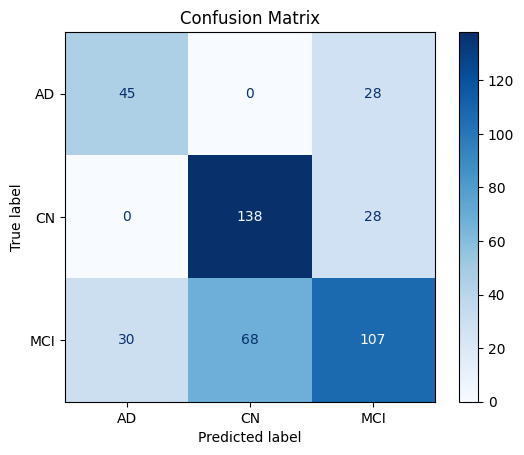

In [17]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)

# MODIFICATION: Update display labels for the 3-class matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [18]:
acc = (all_preds == all_labels).mean()
print(f"\nOverall Test Accuracy: {acc*100:.4f}%")


Overall Test Accuracy: 65.3153%


In [19]:
'''
train_dataset = ScanDataset(X_train, y_train)
test_dataset  = ScanDataset(X_test, y_test)
'''

'\ntrain_dataset = ScanDataset(X_train, y_train)\ntest_dataset  = ScanDataset(X_test, y_test)\n'

In [20]:
'''
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)
'''

'\ntrain_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)\ntest_loader  = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)\n'

In [21]:
'''
class TimeDistributedResNet(nn.Module):
    def __init__(self, base_model):
        super(TimeDistributedResNet, self).__init__()
        self.base_model = base_model

    def forward(self, x):
        # x: (batch, time, 3, 128,128)
        B, T, C, H, W = x.size()
        x = x.view(B*T, C, H, W)
        x = self.base_model(x)                   # (B*T, 2048)
        x = x.view(B, T, -1)                     # (B, T, 2048)
        return x

class ScanLSTMClassifier(nn.Module):
    def __init__(self):
        super(ScanLSTMClassifier, self).__init__()
        base_resnet = models.resnet152(weights='IMAGENET1K_V1')
        base_resnet.fc = nn.Identity()
        self.resnet = TimeDistributedResNet(base_resnet)

        for param in self.resnet.parameters():
            param.requires_grad = False          # freeze ResNet

        self.lstm = nn.LSTM(2048, 512, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.resnet(x)                       # (B, T, 2048)
        _, (hn, _) = self.lstm(x)                # hn: (1, B, 256)
        x = hn.squeeze(0)                        # (B, 256)
        x = F.relu(self.fc1(x))                  # (B, 128)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)).squeeze(-1)  # (B,)
        return x
'''

"\nclass TimeDistributedResNet(nn.Module):\n    def __init__(self, base_model):\n        super(TimeDistributedResNet, self).__init__()\n        self.base_model = base_model\n\n    def forward(self, x):\n        # x: (batch, time, 3, 128,128)\n        B, T, C, H, W = x.size()\n        x = x.view(B*T, C, H, W)\n        x = self.base_model(x)                   # (B*T, 2048)\n        x = x.view(B, T, -1)                     # (B, T, 2048)\n        return x\n\nclass ScanLSTMClassifier(nn.Module):\n    def __init__(self):\n        super(ScanLSTMClassifier, self).__init__()\n        base_resnet = models.resnet152(weights='IMAGENET1K_V1')\n        base_resnet.fc = nn.Identity()\n        self.resnet = TimeDistributedResNet(base_resnet)\n\n        for param in self.resnet.parameters():\n            param.requires_grad = False          # freeze ResNet\n\n        self.lstm = nn.LSTM(2048, 512, batch_first=True)\n        self.fc1 = nn.Linear(256, 128)\n        self.dropout = nn.Dropout(0.3)\n      

In [22]:
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = ScanLSTMClassifier().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-6)
'''

"\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nmodel1 = ScanLSTMClassifier().to(device)\ncriterion = nn.BCELoss()\noptimizer = torch.optim.Adam(model1.parameters(), lr=1e-6)\n"

In [23]:
'''
class ScanDataset(Dataset):
    def __init__(self, scans, labels):
        self.scans = scans
        self.labels = labels

    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        x = self.scans[idx]  # shape: (100, 3, 128, 128)
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
'''

'\nclass ScanDataset(Dataset):\n    def __init__(self, scans, labels):\n        self.scans = scans\n        self.labels = labels\n\n    def __len__(self):\n        return len(self.scans)\n\n    def __getitem__(self, idx):\n        x = self.scans[idx]  # shape: (100, 3, 128, 128)\n        y = self.labels[idx]\n        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)\n'

In [24]:
'''
N = 100  # number of entropy-based slices
crop_size = 128

X, y = [], []

for label, path in tqdm(actual_paths):
    scan = nib.load(path)
    data = scan.get_fdata()
    label_val = 0 if label == 'AD' else 1

    slice_info = []

    for axis in [0, 1, 2]:  
        for i in range(data.shape[axis]):
            # Extract 2D slice along the given axis 
            if axis == 0:
                slice_ = data[i, :, :]
            elif axis == 1:
                slice_ = data[:, i, :]
            else:
                slice_ = data[:, :, i]

            # Crop and skip empty slices
            cropped = center_crop(slice_, crop_size=crop_size)
            if cropped is None:
                continue

            # Compute entropy
            ent = image_entropy(cropped)
            slice_info.append((ent, cropped))

    # Sort slices by entropy
    slice_info.sort(reverse=True, key=lambda x: x[0])
    top_slices = slice_info[:N]

    if len(top_slices) < N:
        print(f"[!] Skipped subject: only {len(top_slices)} slices")
        continue

    subject_slices = []

    for _, slice_2d in top_slices:
        # Grayscale slice is (128,128), add channel axis → (128,128,1)
        slice_2d = slice_2d[..., np.newaxis]

        # Repeat channel 3 times → (128,128,3)
        slice_rgb = np.repeat(slice_2d, 3, axis=-1)

        # Convert to channels-first → (3,128,128)
        slice_rgb_chw = np.transpose(slice_rgb, (2,0,1))

        subject_slices.append(slice_rgb_chw)

    # Stack into (N,3,128,128)
    subject_volume = np.stack(subject_slices, axis=0)

    X.append(subject_volume)
    y.append(label_val)

X = np.stack(X)  # shape: (num_subjects, N, 128, 128, 1)
y = np.array(y)  # shape: (num_subjects,)

'''

'\nN = 100  # number of entropy-based slices\ncrop_size = 128\n\nX, y = [], []\n\nfor label, path in tqdm(actual_paths):\n    scan = nib.load(path)\n    data = scan.get_fdata()\n    label_val = 0 if label == \'AD\' else 1\n\n    slice_info = []\n\n    for axis in [0, 1, 2]:  \n        for i in range(data.shape[axis]):\n            # Extract 2D slice along the given axis \n            if axis == 0:\n                slice_ = data[i, :, :]\n            elif axis == 1:\n                slice_ = data[:, i, :]\n            else:\n                slice_ = data[:, :, i]\n\n            # Crop and skip empty slices\n            cropped = center_crop(slice_, crop_size=crop_size)\n            if cropped is None:\n                continue\n\n            # Compute entropy\n            ent = image_entropy(cropped)\n            slice_info.append((ent, cropped))\n\n    # Sort slices by entropy\n    slice_info.sort(reverse=True, key=lambda x: x[0])\n    top_slices = slice_info[:N]\n\n    if len(top_slic